#### Importando Bibliotecas

In [1]:
from collections import defaultdict
from pacman.actions import Actions
from pacman.env import PacmanEnv
from pacman.agents import Agent

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reinforcement Learning (MO436)

Autores:

**Aline Cavalca Caravlho Soares de Azevedo** (RA: )

**Beatriz Cardoso Nascimento**               (RA: )

**Daniel Gardin Gratti**                     (RA: 214729)

**Guilhermo de Luiggi Mocelim de Oliveira** (RA: )


## Introdução

Reinforcement Learning é um paradigma de Inteligência Artificial baseada em controle

In [2]:
env = PacmanEnv.contourDanger(4, ghost_name= "RobustGhost")

In [3]:
def plot_episodes(episodes, smooth=11, alpha=0.4):
    fig, ax = plt.subplots(figsize=(8, 5))

    n_episode = np.array(range(len(episodes)))


    plt.plot(episodes, alpha=alpha)
    smooth_episode = np.convolve(np.pad(np.array(episodes), (smooth//2,smooth//2), mode='edge'), np.ones(smooth)/smooth, mode='valid')

    ax.plot(smooth_episode, linewidth=2)

    return fig, ax

In [23]:
class EpsilonGreedyQAgent(Agent):
    """
    Generic agent with internal Q table and epsilon-greedy policy.
    This class do not include any default training algorithm.
    """

    def __init__(self):
        self.Qtable = defaultdict(lambda : {action: 0. for action in Actions.actions})
    
    
    def act(self, state, epsilon=0.) -> str:
        if np.random.rand() > epsilon:
            action_values = self.Qtable[state]
            
            action = max(action_values, key=lambda k : action_values[k])

        else:
            action = Actions.sample()

        return action


    def Q(self, state, action):
        return self.Qtable[state][action]
    

    def max_Q(self, state):
        action_values = self.Qtable[state]

        action = max(action_values, key=lambda k : action_values[k])

        return action, action_values[action]
    

    def update_Q(self, state, action, alpha, error):
        self.Qtable[state][action] += alpha * error


    def reset(self):
        """
        Reset agent's Q table.
        """
        self.Qtable.clear()

In [15]:
class BaseController:
    def __init__(self, env):
        self.env    = env

    def train(self, policy):
        pass


### Monte Carlo

In [16]:
class MonteCarloControl(BaseController):
    def __init__(self, env, gamma, alpha=None, N0=1):
        super().__init__(env)

        self.gamma = gamma
        self.alpha = alpha
        self.N0    = N0
    

    def train(self, policy, max_episodes=1000):
        curr_episode = 0

        history = {
            "cumulative reward"  : [],
            "episode error"      : [],
            "episode length"     : [],
            "episode win"        : []
        }

        Ntable  = defaultdict(lambda : {action: 0 for action in Actions.actions})

        while curr_episode < max_episodes:

            state, done = self.env.reset(random_init=True)
            cumulative_reward = 0
            cumulative_error  = 0
            n_steps           = 0

            while not done:
                epsilon = self.N0 / (self.N0 + sum(Ntable[state].values()))

                action = policy.act(state, epsilon)

                next_state, reward, done, info = self.env.step(action)

                Ntable[state][action] += 1
                n_steps += 1
               
                cumulative_reward = (self.gamma * cumulative_reward) + reward

                alpha = 1/Ntable[state][action] if self.alpha is None else self.alpha
                error = (cumulative_reward - policy.Q(state, action))
                policy.update_Q(state, action, alpha, error)

                cumulative_error += abs(error)

                state  = next_state

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)
            history["episode length"].append(n_steps)
            history["episode win"].append(env.is_win())

            curr_episode += 1
        
        return policy, history

In [17]:
monte_carlo = MonteCarloControl(
    env    = env.set_render(None),
    gamma  = 0.99,
    N0     = 10
)
mc_policy, mc_history = monte_carlo.train(EpsilonGreedyQAgent(), 10000)

In [18]:
env.set_render('ansi')
env.run_policy(mc_policy, 0, .5);

% % % % % %
% < M     %
%         %
%         %
%         %
% % % % % %
Score: 43


(<Figure size 800x500 with 1 Axes>, <Axes: >)

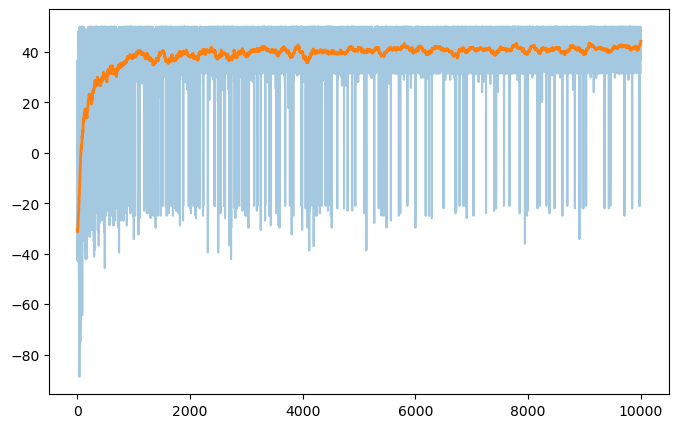

In [19]:
plot_episodes(mc_history["cumulative reward"], smooth=100)

### Q-Learning

In [26]:
class QLearning(BaseController):
    def __init__(self, env, gamma, alpha=None, N0=1):
        super().__init__(env)

        self.gamma = gamma
        self.alpha = alpha
        self.N0    = N0

    
    def train(self, policy, max_episodes=1000):
        curr_episode = 0

        history = {
            "cumulative reward"  : [],
            "episode error"      : [],
            "episode length"     : [],
            "episode win"        : []
        }

        Ntable = defaultdict(lambda : {action: 0 for action in Actions.actions})

        while curr_episode < max_episodes:

            state, done = self.env.reset(random_init=True)
            cumulative_reward = 0
            cumulative_error  = 0

            n_steps = 0

            while not done:
                epsilon = self.N0 / (self.N0 + sum(Ntable[state].values()))

                action = policy.act(state, epsilon)
                next_state, reward, done, info = self.env.step(action)

                Ntable[state][action] += 1
                n_steps += 1

                cumulative_reward = (self.gamma * cumulative_reward) + reward

                _, Qmax = policy.max_Q(next_state)

                td_error = reward + self.gamma * Qmax - policy.Q(state, action)

                cumulative_error += abs(td_error)

                alpha = 1/Ntable[state][action] if self.alpha is None else self.alpha

                policy.update_Q(state, action, alpha, td_error)

                state  = next_state

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)
            history["episode length"].append(n_steps)
            history["episode win"].append(env.is_win())

            curr_episode += 1

        return policy, history

In [27]:
q_learning = QLearning(
    env    = env.set_render(None),
    gamma  = 0.99,
    N0     = 10
)
q_policy, q_history = q_learning.train(EpsilonGreedyQAgent(), 10000)

In [28]:
env.set_render('ansi')
env.run_policy(q_policy, 0, .5);

% % % % % %
% ^ M     %
%         %
%         %
%         %
% % % % % %
Score: 43


(<Figure size 800x500 with 1 Axes>, <Axes: >)

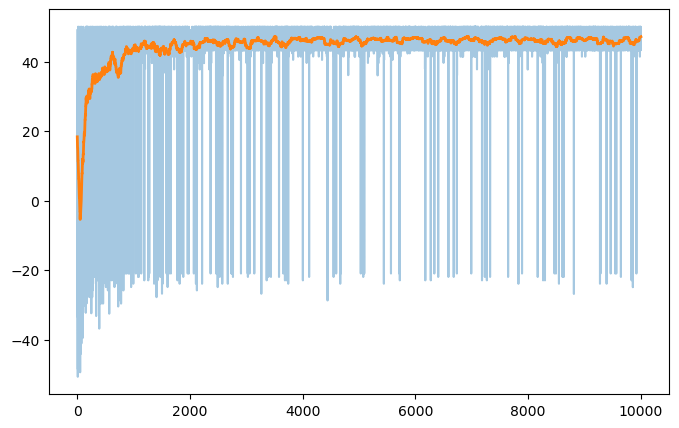

In [29]:
plot_episodes(q_history["cumulative reward"], smooth=101)

### SARSA($\lambda$)

In [36]:
class SARSA(BaseController):
    def __init__(self, env, gamma, lmbda, alpha=None, N0=1):
        super().__init__(env)

        self.gamma = gamma
        self.lmbda = lmbda
        self.alpha = alpha
        self.N0    = N0


    def train(self, policy, max_episodes=None, tol=1e-7):
        curr_episode = 0

        history = {
            "cumulative reward"  : [],
            "episode error"      : [],
            "episode length"     : [],
            "episode win"        : []
        }

        Ntable = defaultdict(lambda : {action: 0 for action in Actions.actions})

        while curr_episode < max_episodes:
            
            Etable  = defaultdict(lambda : {action: 0 for action in Actions.actions})

            state, done = self.env.reset(random_init = True)
            action = policy.act(state, epsilon=1)

            cumulative_reward = 0
            cumulative_error  = 0

            n_steps = 0

            while not done:
                Etable[state][action] = Etable[state][action] + 1

                next_state, reward, done, info = self.env.step(action)

                epsilon = self.N0 / (self.N0 + sum(Ntable[next_state].values()))

                next_action = policy.act(next_state, epsilon)

                Ntable[state][action] += 1
                n_steps += 1

                cumulative_reward = (self.gamma * cumulative_reward) + reward

                td_error = reward + self.gamma * policy.Q(next_state, next_action) - policy.Q(state, action)

                cumulative_error += abs(td_error)

                alpha = 1/Ntable[state][action] if self.alpha is None else self.alpha

                for state in Etable:
                    for action in Actions.actions:
                        policy.update_Q(state, action, alpha, td_error * Etable[state][action])
                        Etable[state][action] *= self.gamma * self.lmbda

                state  = next_state
                action = next_action

            history["cumulative reward"].append(cumulative_reward)
            history["episode error"].append(cumulative_error)
            history["episode length"].append(n_steps)
            history["episode win"].append(env.is_win())

            curr_episode += 1
        
        return policy, history

In [37]:
sarsa = SARSA(
    env    = env.set_render(None),
    gamma  = 0.99,
    lmbda  = 0.2,
    N0     = 10
)
sarsa_policy, sarsa_history = sarsa.train(EpsilonGreedyQAgent(), 10000)

In [38]:
env.set_render('ansi')
env.run_policy(sarsa_policy, 0, .5);

% % % % % %
% ^ M     %
%         %
%         %
%         %
% % % % % %
Score: 43


(<Figure size 800x500 with 1 Axes>, <Axes: >)

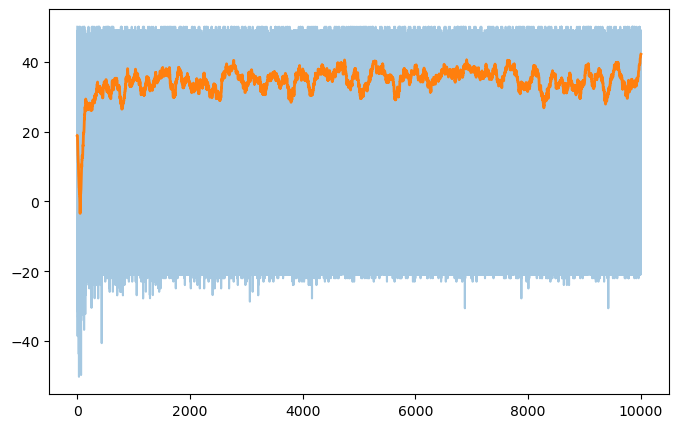

In [39]:
plot_episodes(sarsa_history["cumulative reward"], smooth=101)

## Linear Features

In [ ]:
class EpsilonGreedyLinearAgent(Agent):
    """
    Generic agent with internal Q table and epsilon-greedy policy.
    This class do not include any default training algorithm.
    """

    def __init__(self, state_dim, action_dim):
        self.weights = np.zeros(action_dim, state_dim)
    
    
    def act(self, state, epsilon=0.) -> str:
        if np.random.rand() > epsilon:
            action_values = self.Qtable[state]
            
            action = max(action_values, key=lambda k : action_values[k])

        else:
            action = Actions.sample()

        return action


    def Q(self, state, action):
        idx = Actions.action_index(action)

        return (self.weights @ state)[idx]
    

    def max_Q(self, state):
        Qvalues = (self.weights @ state)

        idx = np.argmax(Qvalues)

        return Actions.actions[idx], Qvalues[idx]
    

    def update_Q(self, state, action, alpha, error):
        self.Qtable[state][action] += alpha * error


    def reset(self):
        """
        Reset agent's Q table.
        """
        self.weights = np.zeros(action_dim, state_dim)